In [ ]:
!pip3 install mne
!pip install POT
!git clone https://github.com/vpeterson/otda-mibci.git

In [ ]:
import numpy as np
import sys
sys.path.insert(1, 'otda-mibci')
from MIOTDAfunctions import*
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import mne
from mne.decoding import CSP
mne.set_log_level(verbose='warning') #to avoid info at terminal
from  random import sample
from sklearn.metrics import balanced_accuracy_score


In [ ]:
def Backward_GroupLasso_Transport(Gtr_daot, Ytr_daot, regu_, Gtr, Ytr, Gval, Yval, Gte, lda, metric):
      
    botda = ot.da.SinkhornL1l2Transport(metric=metric, reg_e=regu_[0], reg_cl=regu_[1])
    # learn params of transport
    botda.fit(Xs=Gval, ys=Yval, Xt=Gtr_daot)
    botda_matrix = botda.coupling_
    #transport testing samples
    transp_Xt_backward=botda.transform(Xs=Gte)
    
    # Compute accuracy without retraining    
    yt_predict = lda.predict(transp_Xt_backward) 
    
    return yt_predict, transp_Xt_backward, botda_matrix

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os.path as op
data_path = op.join('/content/drive/MyDrive/Proyecto_coadaptiveBCI/Simulaciones/simulated data/MI vs rest')


In [ ]:
# %% Load Training data - session 1
Data_S1 = op.join(data_path, 'session1_epochs_epo.fif')
epochs_S1 = mne.read_epochs(Data_S1, preload=True, verbose=False)
# resample to 250 Hz
epochs_S1 = epochs_S1.resample(250)
epochs_S1_array = epochs_S1.get_data()  # Epoched data as a numpy array
# filter data between 8 an 30 hz
epochs_S1_array=mne.filter.filter_data(epochs_S1_array, 250, 8, 30)

ch_names = epochs_S1.ch_names  # Channels names

ERD = [0.5, 0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1]

In [ ]:
np.shape(epochs_S1_array) # trials.ch.samples

(200, 41, 1000)

<Figure size 640x480 with 0 Axes>

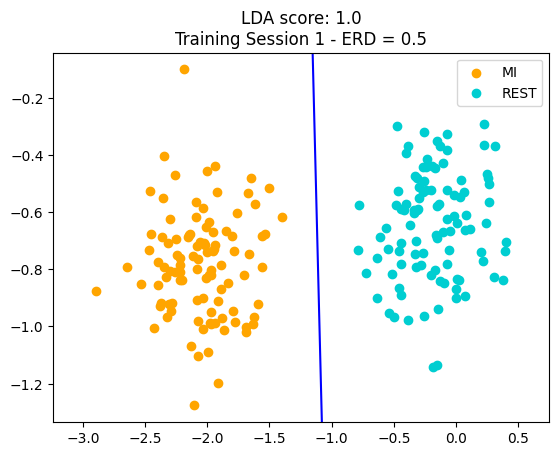

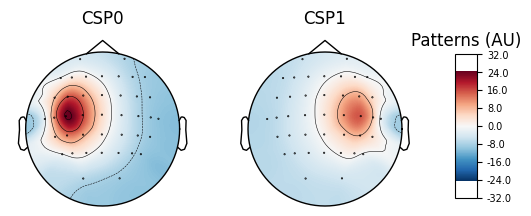

In [ ]:
#%% Training - Learn CSP+LDA from source data
Xtr = epochs_S1_array
Ytr = epochs_S1.events[:,2]
csp = CSP(n_components=2, reg='empirical', log=True, norm_trace=False, cov_est='epoch') #creating obj
#learn csp filters
Gtr = csp.fit_transform(Xtr, Ytr)
#learn lda
lda = LinearDiscriminantAnalysis()
lda.fit(Gtr,Ytr)
lda.score(Gtr,Ytr)

fig = csp.plot_patterns(epochs_S1.info, ch_type='eeg', units='Patterns (AU)', size=1.5)



In [ ]:
#Plot first 2 features
features = Gtr[:,0:2]
plt.figure()
fig, axs = plt.subplots()
axs.scatter(features[Ytr==1, 0], features[Ytr==1, 1], c='orange', label='MI')
axs.scatter(features[Ytr==2, 0], features[Ytr==2, 1], c='darkturquoise', label='REST')
axs.set_title("LDA score: " + str(lda.score(Gtr,Ytr)) + "\nTraining Session 1 - ERD = " + str(ERD[0]))
b, w1, w2 = lda.intercept_[0], lda.coef_[0][0], lda.coef_[0][1]
xx = np.array(axs.get_xlim())
xlim = xx
ylim = np.array(axs.get_ylim())
axs.plot(xx, -(b+xx*w1)/w2, c='blue')
axs.set_ylim(ylim)
axs.legend()

In [ ]:
#split S2 in testing validation
i = 2 #%ERD=50
Data_S2 = op.join(data_path, 'session' + str(i) +'_epochs_epo.fif')  
epochs_S2 = mne.read_epochs(Data_S2, preload=True, verbose=False)
# resample to 250 Hz
epochs_S2 = epochs_S2.resample(250)
epochs_S2_array = epochs_S2.get_data()  # Epoched data as a numpy array
# Filter data 
epochs_S2_array=mne.filter.filter_data(epochs_S2_array, 250, 8, 30)

In [ ]:
Xte = epochs_S2_array
Yte = epochs_S2.events[:,2]

In [ ]:
#%% OTDA parameters
rango_cl=[0.1, 1, 10]
rango_e=[0.1, 1, 10] 
metric = 'sqeuclidean'
outerkfold = 20
innerkfold = None
M=20
norm=None
eps = 1e+6

In [ ]:
# select source subset
# Use the first 20 trials as the validation set
Xval=Xte[0:20].copy()
Yval=Yte[0:20].copy()

# features val
Gval=csp.transform(Xval)

In [ ]:
G_BOTDAl1l2_, Y_BOTDAl1l2_, regu_BOTDAl1l2_=\
SelectSubsetTraining_BOTDAl1l2(Gtr, Ytr, Gval, Yval, rango_e, rango_cl, lda, metric, outerkfold, innerkfold, M, norm)

regu_BOTDAl1l2_ #print regu

/usr/local/lib/python3.9/dist-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "
/usr/local/lib/python3.9/dist-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "
/usr/local/lib/python3.9/dist-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "
/usr/local/lib/python3.9/dist-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.


[0.1, 10]

In [ ]:
acc_lda = []
acc_OT = []  
perc = [0, 0.1, 0.2, 0.3, 0.4, 0.5]
Yte_new = Yte[20:].copy() #avoid the first 20 trials of val
Xte_new = Xte[20:].copy()
# prubo LDA solo
for p in perc:
    print(p)

    
    if p > 0:       
        idx = np.where(Yte_new == 2)[0] #only in testing idx    
        n_change = np.array(sample(list(idx), int(p*len(idx))))
        Yte_new[n_change] = 1
    
    #LDA
    Gte=csp.transform(Xte_new)
    y_predict_lda = lda.predict(Gte)
    acc_lda.append(balanced_accuracy_score(Yte_new, y_predict_lda))
print(acc_lda)

0
0.1
0.2
0.3
0.4
0.5
[1.0, 0.9536082474226804, 0.8893805309734513, 0.8308270676691729, 0.7913907284768211, 0.7666666666666666]


In [ ]:
acc_OT = []  
perc = [0, 0.1, 0.2, 0.3, 0.4, 0.5]
Yte_new = Yte[20:].copy() #avoid the first 20 trials of val
Xte_new = Xte[20:].copy()
# prubo OT solo
for p in perc:
    print(p)

    if p > 0:       
        idx = np.where(Yte_new == 2)[0] #only in testing idx    
        n_change = np.array(sample(list(idx), int(p*len(idx))))
        Yte_new[n_change] = 1

    # OT
    yt_predict = []
    Transp = []
    Xval_ot = Xval.copy()
    Yval_ot = Yval.copy()
    #  For each sample, make the data adaptation
    for re in range(len(Yte_new)):
        
        #testing trial
        Xte_ot=Xte_new[re:re+1]
        Yte_ot=Yte_new[re:re+1]
        
        Xval_ot=np.vstack((Xval_ot, Xte_ot))
        Yval_ot=np.hstack((Yval_ot, Yte_ot))
        
        #csp estimation
        Gval_ot=csp.transform(Xval_ot)
        Gte_ot=csp.transform(Xte_ot)
     
        yt_pred, transp_Xt_backward, botda_matrix = Backward_GroupLasso_Transport(G_BOTDAl1l2_, Y_BOTDAl1l2_, regu_BOTDAl1l2_, Gtr, Ytr, Gval_ot, Yval_ot, Gte_ot, lda, metric)
        yt_predict.append(yt_pred)
        #save transported data
        Transp.append(transp_Xt_backward)
      
    Gte_ot=np.squeeze(Transp)
    yt_predict = np.squeeze(yt_predict)
    
    acc_OT.append(balanced_accuracy_score(Yte_new, yt_predict)) #########
    
    #Plot first 2 features
    ft = Gte[:,0:2]
    ft_ot = Gte_ot[:,0:2]
    
    x = np.linspace(-1,3,500)
    y = np.linspace(2,8,500)
    X,Y = np.meshgrid(x,y)
    pos = np.array([X.flatten(),Y.flatten()]).T
    fig, axs = plt.subplots()
    axs.scatter(ft[Yte_new==2, 0], ft[Yte_new==2, 1], c='darkturquoise', label='REST ')  
    axs.scatter(ft_ot[Yte_new==2, 0], ft_ot[Yte_new==2, 1], c='teal', label='REST OT')
    axs.scatter(ft[Yte_new==1, 0], ft[Yte_new==1, 1], c='orange', label='MI')  
    axs.scatter(ft_ot[Yte_new==1, 0], ft_ot[Yte_new==1, 1], c='chocolate', label='MI OT')  
   
    axs.set_title('Accuracy LDA: ' + str(balanced_accuracy_score(Yte_new,y_predict_lda))[0:5] + 
                  '\nAccuracy OT: ' + str(balanced_accuracy_score(Yte_new,yt_predict))[0:5] + '\nS2 p_failed: ' + str(p))
    axs.legend(loc='upper left')               
    b, w1, w2 = lda.intercept_[0], lda.coef_[0][0], lda.coef_[0][1]
    xx = np.array(axs.get_xlim())
    #ylim = np.array(axs.get_ylim())
    axs.plot(xx, -(b+xx*w1)/w2, c='blue')
    axs.set_ylim(ylim)
    axs.set_xlim(xlim)
    #plt.savefig(result_path + '\pFailed_' + str(p) + '.svg')
    plt.show()

print (acc_OT)


acc_lda = [round(item, 2) for item in acc_lda]
acc_OT = [round(item, 2) for item in acc_OT]
fig, axs = plt.subplots()
x = np.arange(len(perc))
bar1 = plt.bar(x-0.2, acc_lda, 0.4, color='orange', label='without OT')
bar2 = plt.bar(x+0.2, acc_OT, 0.4, color='chocolate', label='with OT')
plt.title('Classification Accuracy')
plt.xlabel("ERD")
plt.ylabel("Accuracy")
plt.ylim([0,1])
#plt.xticks(x, np.squeeze(ERD[[perc-1]]))
plt.legend(loc='lower right')
 
def autolabel(rects):
  """Attach a text label above each bar in *rects*, displaying its height."""
  for rect in rects:
        height = rect.get_height()
        plt.annotate('{}'.format(height),
                  xy=(rect.get_x() + rect.get_width() / 2, height),
                  xytext=(0, 3),  # 3 points vertical offset
                  textcoords="offset points",
                  ha='center', va='bottom')
autolabel(bar1)
autolabel(bar2)
fig.tight_layout()
 
#plt.savefig(result_path +  '\ACCURACY_PFailed' + '.svg')
plt.show()
    
x = np.array(range(0,6))
degree = 2
coefficients_lda = np.polyfit(x, acc_lda, degree)
poly_lda = np.poly1d(coefficients_lda)
fit_lda = poly_lda(x)

coefficients_OT = np.polyfit(x, acc_OT, degree)
poly_OT = np.poly1d(coefficients_OT)
fit_OT = poly_OT(x)

# Plot the original data and the fitted curves

plt.plot(x, acc_lda, 'o', color='orange', markersize=12,  label='LDA')
plt.plot(x, fit_lda, color='orange', label='Fitted Curve (LDA)')
plt.plot(x, acc_OT, 'o', color='chocolate', markersize=6, label='OT')
plt.plot(x, fit_OT, color='chocolate', label='Fitted Curve (OT)')

plt.xlabel('Sessions')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()
